#Youtube Title and Comments Classifier Process
Max Karambelas, George Trammell, EJ Wong

##Cleaning

In [ ]:
import numpy as np
import datetime

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/USvideos.csv')
df.head()

In [ ]:
!pip install transformers
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 23.6 MB/s 
     |████████████████████████████████| 7.6 MB 63.2 MB/s 
     |████████████████████████████████| 182 kB 61.7 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df[['pubYear', 'pubMonth', 'null1']] = df['publish_time'].str.split('-', expand=True)
df[['pubDate', 'pubTime']] = df['publish_time'].str.split('T', 1, expand=True)
df['pubDate'] = df['pubDate'].astype('string')
df['pubDate'] = pd.to_datetime(df['pubDate'])
df['trending_date'] = df['trending_date'].astype('string')
df['trending_date'] = df['trending_date'].str.replace('.','/')
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y/%d/%m')
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,pubYear,pubMonth,null1,pubDate,pubTime
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017,11,13T17:13:01.000Z,2017-11-13,17:13:01.000Z
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",2017,11,13T07:30:00.000Z,2017-11-13,07:30:00.000Z
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,2017,11,12T19:05:24.000Z,2017-11-12,19:05:24.000Z
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,2017,11,13T11:00:04.000Z,2017-11-13,11:00:04.000Z
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,2017,11,12T18:01:41.000Z,2017-11-12,18:01:41.000Z


In [ ]:
df['normViews'] = df.groupby('pubYear').views.apply(lambda x: (x - min(x))/(max(x)-min(x)))
df['normLikes'] = df.groupby('pubYear').likes.apply(lambda x: (x - min(x))/(max(x)-min(x)))
df['normDislikes'] = df.groupby('pubYear').dislikes.apply(lambda x: (x - min(x))/(max(x)-min(x)))
df['normComment_count'] = df.groupby('pubYear').comment_count.apply(lambda x: (x - min(x))/(max(x)-min(x)))
df.describe()

,category_id,views,likes,dislikes,comment_count,normViews,normLikes,normDislikes,normComment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04,40948.000000,40948.000000,40948.000000,40948.000000
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03,0.012809,0.016396,0.003469,0.008392
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04,0.046979,0.055784,0.035366,0.044692
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02,0.001233,0.001179,0.000124,0.000526
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03,0.003364,0.003743,0.000385,0.001575
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03,0.008999,0.011394,0.001194,0.004836
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06,1.000000,1.000000,1.000000,1.000000


In [ ]:
df['timeTrending'] = df['trending_date'] - df['pubDate']
df['quantile'] = pd.qcut(df['timeTrending'], 5, labels=False)
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,pubMonth,null1,pubDate,pubTime,normViews,normLikes,normDislikes,normComment_count,timeTrending,quantile
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,11,13T17:13:01.000Z,2017-11-13,17:13:01.000Z,0.005005,0.018596,0.001805,0.019274,1 days,0
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,11,13T07:30:00.000Z,2017-11-13,07:30:00.000Z,0.016188,0.031415,0.003741,0.015346,1 days,0
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,11,12T19:05:24.000Z,2017-11-12,19:05:24.000Z,0.021361,0.047206,0.003249,0.009883,2 days,0
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,11,13T11:00:04.000Z,2017-11-13,11:00:04.000Z,0.002293,0.003288,0.000405,0.002593,1 days,0
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,11,12T18:01:41.000Z,2017-11-12,18:01:41.000Z,0.014025,0.042745,0.001211,0.021163,2 days,0


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
df["title"] = df['title'].str.replace('[^\w\s]','')
df['tokenized_titles'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
x = df['tokenized_titles']
y = df['quantile']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.25, random_state = 42)
df.head()
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,null1,pubDate,pubTime,normViews,normLikes,normDislikes,normComment_count,timeTrending,quantile,tokenized_titles
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,13T17:13:01.000Z,2017-11-13,17:13:01.000Z,0.005005,0.018596,0.001805,0.019274,1 days,0,"[WE, WANT, TO, TALK, ABOUT, OUR, MARRIAGE]"
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency Last Week Tonight with Jo...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,13T07:30:00.000Z,2017-11-13,07:30:00.000Z,0.016188,0.031415,0.003741,0.015346,1 days,0,"[The, Trump, Presidency, Last, Week, Tonight, ..."
2,5qpjK5DgCt4,2017-11-14,Racist Superman Rudy Mancuso King Bach Lele ...,Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,12T19:05:24.000Z,2017-11-12,19:05:24.000Z,0.021361,0.047206,0.003249,0.009883,2 days,0,"[Racist, Superman, Rudy, Mancuso, King, Bach, ..."
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics Real or Fake,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,13T11:00:04.000Z,2017-11-13,11:00:04.000Z,0.002293,0.003288,0.000405,0.002593,1 days,0,"[Nickelback, Lyrics, Real, or, Fake]"
4,d380meD0W0M,2017-11-14,I Dare You GOING BALD,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,12T18:01:41.000Z,2017-11-12,18:01:41.000Z,0.014025,0.042745,0.001211,0.021163,2 days,0,"[I, Dare, You, GOING, BALD]"


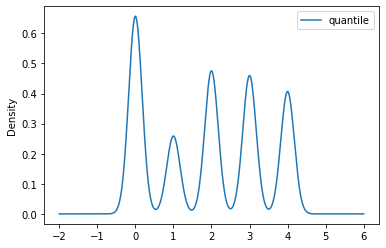

In [ ]:
from matplotlib import pyplot
buckets = df[['quantile']]
buckets.plot(kind="kde")
pyplot.show()

##Naive Bayes Model

In [ ]:
ratings_data = df[['title', 'quantile']]
ratings_data.insert(0, 'num', range(1, 1 + len(ratings_data)))
ratings_data.head()

,num,title,quantile
0,1,WE WANT TO TALK ABOUT OUR MARRIAGE,0
1,2,The Trump Presidency Last Week Tonight with Jo...,0
2,3,Racist Superman Rudy Mancuso King Bach Lele ...,0
3,4,Nickelback Lyrics Real or Fake,0
4,5,I Dare You GOING BALD,0


In [ ]:
ratings_data.to_csv('ratings_data.txt', sep = '\t', index=False)
print(ratings_data)
with open('ratings_data.txt', 'r') as textfile:
  ratings_data = textfile.read()

         num                                              title  quantile
0          1                 WE WANT TO TALK ABOUT OUR MARRIAGE         0
1          2  The Trump Presidency Last Week Tonight with Jo...         0
2          3  Racist Superman  Rudy Mancuso King Bach  Lele ...         0
3          4                     Nickelback Lyrics Real or Fake         0
4          5                              I Dare You GOING BALD         0
...      ...                                                ...       ...
40944  40945                       The Cat Who Caught the Laser         4
40945  40946                          True Facts  Ant Mutualism         4
40946  40947  I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...         4
40947  40948                How Black Panther Should Have Ended         4
40948  40949  Official Call of Duty Black Ops 4  Multiplayer...         4

[40949 rows x 3 columns]


In [ ]:
from nltk.tokenize import word_tokenize

def tokenize(sentence):
    return [t.lower() for t in word_tokenize(sentence)]

class ModelInfo:
    def __init__(self):
        self.word_counts = [{}, {}, {}, {}, {}]
        self.sentiment_counts = [0, 0, 0, 0, 0]
        self.total_words = [0, 0, 0, 0, 0]
        self.total_examples = 0


    def update_word_counts(self, sentence, sentiment):
        # Get the relevant dicts for the sentiment
        s_word_counts = self.word_counts[sentiment]
        tokens = tokenize(sentence)
        for token in tokens:
            self.total_words[sentiment] += 1
            s_word_counts[token] = s_word_counts.get(token, 0) + 1

FIRST_SENTENCE_NUM = 1

def get_models(ratings_data):
    next_fresh = FIRST_SENTENCE_NUM
    info = ModelInfo()
    for line in ratings_data.splitlines():
        if line.startswith("---"):
            return info
        fields = line.split("\t")
        try:
            sentence_num = int(fields[0])
            if sentence_num <= next_fresh:
                continue
            next_fresh += 1
            sentiment = int(fields[2])
            info.sentiment_counts[sentiment] += 1
            info.total_examples += 1
            info.update_word_counts(fields[1], sentiment)
        except ValueError:
            continue
    return info
model_info = get_models(ratings_data)

In [ ]:
import math
import math
import operator
from functools import reduce
OUT_OF_VOCAB_PROB = 0.0000000001

def naive_bayes_classify(info, sentence):
    tkns = tokenize(sentence)
    # P(Sentiment)
    pSent = [info.sentiment_counts[i]/info.total_examples for i in range(5)]
    # P(word)
    pWord = (1/len(tkns))

    def prod(factors):
        return reduce(operator.mul, factors, 1)

    final = []

    # P(word|sentiment=k)
    def probWordGivenSentiment(token, sentiment):
      if token in info.word_counts[sentiment]:
        tokenIndex = list(info.word_counts[sentiment].keys()).index(token)
        tokenCount =  list(info.word_counts[sentiment].values())[tokenIndex]
        return tokenCount/info.total_words[sentiment]
      else:
        return OUT_OF_VOCAB_PROB

    for i in range(5):
      likelihoods = []
      for j in tkns:
        likelihoods.append(probWordGivenSentiment(j, i))

      product = prod(likelihoods)

      final.append(math.log(pSent[i]) + math.log(product))
    
    #use max for all of the class and probs
    best_class = final.index(max(final))
    best_log_prob = max(final)
    
    return best_class, best_log_prob

## Naive Bayes Tests

In [ ]:
#4 video from list
print(naive_bayes_classify(model_info, "The Cat Who Caught the Laser"))

(4, -38.05248615494952)


In [ ]:
print(naive_bayes_classify(model_info, "bad title"))
#obviously bad title I made up

(0, -17.980624465569527)


In [ ]:
print(naive_bayes_classify(model_info, "Amazing Must Watch Crazy Insane Video"))
#decent title I made up

(2, -49.236620166280545)


In [ ]:
print(naive_bayes_classify(model_info, "The Trump Presidency Last Week Tonight with"))
#0 video from list

(0, -48.33424383657226)


## Naive Bayes Self Tester

In [ ]:
titleVar = "Greatest Classifier Ever" #@param {type:"string"}
rating, logp = naive_bayes_classify(model_info, titleVar)
print('Your Titles Rating:', rating)
print('The Log Probability of Your Title:', logp)

Your Titles Rating: 3
The Log Probability of Your Title: -39.12631165263355


## VADER | BERT

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/Shareddrives/Ds340Project/UScomments.csv', encoding = "ISO-8859-1")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# cleaning
df['comment_text'] = df['comment_text'].str.replace('[^0-9a-zA-Z.,-/ ]', '')
df['comment_text'] = df['comment_text'].astype(str)

<ipython-input-10-6a7065670657>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment_text'] = df['comment_text'].str.replace('[^0-9a-zA-Z.,-/ ]', '')


In [ ]:
# vader sentiment intensity labeling, pre-BERT
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

# using compound vader score (-1 to 1, float)
def vader_sentiment_result(sent):
    scores = analyzer.polarity_scores(sent)
    return scores["compound"]

df["vader_result"] = df["comment_text"].apply(lambda x: vader_sentiment_result(x))
df
# lots of 0's because a lot of the comments have no sentimental value... fair, vader actually does a pretty good job as far as I'm concerned

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,video_id,comment_text,likes,replies,vader_result
0,XpVt6Z1Gjjo,Logan Paul its yo big day,4,0,0.0000
1,XpVt6Z1Gjjo,Ive been following you from the start of your ...,3,0,0.0000
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0,0.0000
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0,0.4648
4,XpVt6Z1Gjjo,trending,3,0,0.0000
...,...,...,...,...,...
691402,EoejGgUNmVU,,1,0,0.0000
691403,EoejGgUNmVU,quest ce que jaimerais que tu viennes Roanne,0,0,0.0000
691404,EoejGgUNmVU,Ven a mexico te amo LP,0,0,0.0000
691405,EoejGgUNmVU,Isl yeter...,0,0,0.0000


In [ ]:
# use pretrained BERT model (all-MiniLM-L6-v2) to find similar sentences
from sentence_transformers import SentenceTransformer, util

# comments to list for easy embedding
comments_list = df.comment_text.values.tolist()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(comments_list)

print(len(embeddings)) # should print 691407

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

691407


In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# turn embedding into tensor
import torch

comments_tensor = torch.tensor(embeddings)

In [ ]:
def findAverageSentiment(top10, index):
  # list of vader scores for top 10 most similar comments
  vader_scores = []
  # list of their IDs for debugging/later analysis
  similar_sentimentsID = []

  for comment in top10[0]:
    score = comment.get("score")
    corpus_id = comment.get("corpus_id")

    if score >= 1:
      continue
    else:
      similar_sentimentsID.append(corpus_id)
      vader_scores.append(df.at[corpus_id, "vader_result"])

  average_sentiment = sum(vader_scores)/10
  df.loc[index, 'average_sentiment'] = average_sentiment

indexer = -1
for comment in embeddings[:100]: # SAMPLING SLICE
  indexer += 1

  if indexer % 10 == 0:
    print("reached ", indexer) # DEBUG

  # grabbing top 11 because one will be itself
  top10 = util.semantic_search(comment, comments_tensor, query_chunk_size = 100000000, corpus_chunk_size = 100000000000, top_k = 11)

  # indexer keeps track of current row
  findAverageSentiment(top10, indexer)
df

reached  0
reached  10
reached  20
reached  30
reached  40
reached  50
reached  60
reached  70
reached  80
reached  90


,video_id,comment_text,likes,replies,vader_result,average_sentiment
0,XpVt6Z1Gjjo,Logan Paul its yo big day,4,0,0.0000,0.00000
1,XpVt6Z1Gjjo,Ive been following you from the start of your ...,3,0,0.0000,0.01988
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0,0.0000,0.10537
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0,0.4648,0.21334
4,XpVt6Z1Gjjo,trending,3,0,0.0000,0.00000
...,...,...,...,...,...,...
691402,EoejGgUNmVU,,1,0,0.0000,NaN
691403,EoejGgUNmVU,quest ce que jaimerais que tu viennes Roanne,0,0,0.0000,NaN
691404,EoejGgUNmVU,Ven a mexico te amo LP,0,0,0.0000,NaN
691405,EoejGgUNmVU,Isl yeter...,0,0,0.0000,NaN


In [ ]:
# using sum as this means we automatically ignore comments with no sentiment (set to 0 by vader)
df2 = df.groupby(by='video_id')['average_sentiment'].sum()
df2

video_id
-1fzGnFwz9M    0.0
-3AGlBYyLjo    0.0
-5sCWsLlTCI    0.0
-6Zc8Co2H3w    0.0
-C-LJUD2LWU    0.0
              ... 
zqE-ultsWt0    0.0
zrOHeEA14kQ    0.0
zuKX0fPlo2Q    0.0
zuUQDdWNAPc    0.0
zyPIdeF4NFI    0.0
Name: average_sentiment, Length: 2266, dtype: float64